In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit

In [7]:
operation_count = 0
np.random.seed(1)

def generate_random_matrix(size):
    return np.random.uniform(1e-8, 1.0, (size, size))

def add_matrix(A, B):
    global operation_count
    operation_count += A.shape[0] * B.shape[0]
    return A + B

def sub_matrix(A, B):
    global operation_count
    operation_count += A.shape[0] * B.shape[0]
    return A - B

def next_power_of_two(n):
    return 1 if n == 0 else 1 << n.bit_length()

def pad_to_power_of_two(matrix, target_size):
    padded_matrix = np.zeros((target_size, target_size))
    padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    return padded_matrix

def mul(A, B):
    A_rows, A_cols = A.shape if A.ndim > 1 else (A.shape[0], 1)
    B_rows, B_cols = B.shape if B.ndim > 1 else (B.shape[0], 1) 

    max_dim = max(A_rows, A_cols, B_rows, B_cols)
    target_size = next_power_of_two(max_dim)

    A_padded = pad_to_power_of_two(A, target_size)
    if B.ndim == 1:
        B_padded = np.zeros((target_size, target_size))
        B_padded[:B.shape[0], 0] = B
        return strassen_recursive(A_padded, B_padded)[:A.shape[0], 0]
    
    B_padded = pad_to_power_of_two(B, target_size)
    return strassen_recursive(A_padded, B_padded)[:A.shape[0], :B.shape[1]]


def strassen_recursive(A, B):
    global operation_count

    n = A.shape[0]
    if n == 1:
        operation_count += 1
        return A * B
    elif A[0 ,0] == 0:
        return np.zeros_like(A)
    
    mid = n // 2

    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    B11 = B[:mid, :mid]
    B12 = B[:mid, mid:]
    B21 = B[mid:, :mid]
    B22 = B[mid:, mid:]

    operation_count += mid * mid * 10 
    P1 = strassen_recursive(A11 + A22, B11 + B22)
    P2 = strassen_recursive(A21 + A22, B11)
    P3 = strassen_recursive(A11, B12 - B22)
    P4 = strassen_recursive(A22, B21 - B11)
    P5 = strassen_recursive(A11 + A12, B22)
    P6 = strassen_recursive(A21 - A11, B11 + B12)
    P7 = strassen_recursive(A12 - A22, B21 + B22)

    operation_count += mid * mid * 8
    C11 = P1 + P4 - P5 + P7
    C12 = P3 + P5
    C21 = P2 + P4
    C22 = P1 + P3 - P2 + P6

    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))

    return C

In [ ]:
start = 1
stop = 50
operations1 = []

for test_num in range(start, stop+1):
    A = generate_random_matrix(test_num)
    B = generate_random_matrix(test_num)
    
    operation_count = 0
    matrix_mul = mul(A, B)
    operations1.append(operation_count)
    matrix_mul_numpy = A @ B

    if np.allclose(matrix_mul, matrix_mul_numpy):
        # print(f"Test passed for random A of size {test_num}x{test_num}")
        continue
    else:
        print(f"Test failed for random A of size {test_num}x{test_num}")
        print("Solution using recursive inverse:")
        print(matrix_mul)

        print("Expected solution:")
        print(matrix_mul_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

## Rekurencyjne odwracanie macierzy

In [9]:
def recursive_matrix_inverse(A):
    n = A.shape[0]

    if n == 1:
        return np.array([[1 / A[0, 0]]])
    
    mid = n // 2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    A11_inv = recursive_matrix_inverse(A11)

    S = A22 - mul(mul(A21, A11_inv), A12)

    S_inv = recursive_matrix_inverse(S)
    B11 = A11_inv + mul(mul(mul(mul(A11_inv, A12), S_inv), A21), A11_inv)
    B12 = mul(mul(-A11_inv, A12), S_inv)
    B21 = mul(mul(-S_inv, A21), A11_inv)
    B22 = S_inv

    A_inverse = np.vstack((
        np.hstack((B11, B12)),
        np.hstack((B21, B22))
        ))

    return A_inverse

In [ ]:
start = 1
stop = 30

for test_num in range(start, stop+1):
    matrix = generate_random_matrix(test_num)

    while np.linalg.det(matrix) == 0:
        matrix = generate_random_matrix(test_num)
    
    matrix_inv_recursive = recursive_matrix_inverse(matrix)
    matrix_inv_numpy = np.linalg.inv(matrix)

    if np.allclose(matrix_inv_recursive, matrix_inv_numpy):
        # print(f"Test passed for random matrix of size {test_num}x{test_num}")
        continue
    else:
        print(f"Test failed for random matrix of size {test_num}x{test_num}")
        print("Solution using recursive inverse:")
        print(matrix_inv_recursive)

        print("Expected solution:")
        print(matrix_inv_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

## Rekurencyjna LU faktoryzacja 

In [22]:
def lu_recursive(A):
    n = A.shape[0]

    if n == 1:
        return np.array([[1]]), np.array([[A[0,0]]])
    
    mid = (n + 1) // 2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    L11, U11 = lu_recursive(A11)
    U11_inv = recursive_matrix_inverse(U11)
    L11_inv = recursive_matrix_inverse(L11)

    L21 = mul(A21, U11_inv)
    U12 = mul(L11_inv, A12) 

    S = A22 - mul(L21, U12)
    Ls, Us = lu_recursive(S)

    L = np.block([
        [L11, np.zeros((mid, A.shape[1] - mid))],
        [L21, Ls]
    ])

    U = np.block([
        [U11, U12],
        [np.zeros((A.shape[0] - mid, mid)), Us]
    ])

    return L, U

In [65]:
start = 1
stop = 40

for test_num in range(start, stop+1):
    matrix = generate_random_matrix(test_num)
    
    L, U = lu_recursive(matrix)
    matrix_reconstructed = L @ U

    if np.allclose(matrix, matrix_reconstructed):
        # print(f"Test passed for random matrix of size {test_num}x{test_num}")
        continue

    else:
        print(f"Test failed for random matrix of size {test_num}x{test_num}")
        print("Solution using lu recursive:")
        print(matrix_inv_recursive)

        print("Expected solution:")
        print(matrix_inv_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

Test passed for random square matrices of sizes 1x1 to 40x40


## Rekurencyjne obliczanie wyznacznika macierzy

In [28]:
def recursive_determinant_lu(A):
    L, U = lu_recursive(A)
    return np.prod(np.diag(L)) * np.prod(np.diag(U))

In [ ]:
start = 1
stop = 50

for test_num in range(start, stop+1):
    A = generate_random_matrix(test_num)

    A_det_recursive = recursive_determinant_lu(A)
    A_det_numpy = np.linalg.det(A)    
    
    if np.allclose(A_det_recursive, A_det_numpy):
        # print(f"Test passed for random A of size {test_num}x{test_num}")
        continue
    else:
        print(f"Test failed for random square matrices of size {test_num}x{test_num}")
        print("Solution using recursive determinant:")
        print(A_det_recursive)

        print("Expected solution:")
        print(A_det_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

## Rekurencyjna eliminacja Gaussa

In [38]:
def recursive_gaussian_elimination(A, b):
    n = A.shape[0]

    if n == 1:
        return np.array([b[0] / A[0, 0]])
    
    mid = n // 2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    b1 = b[:mid]
    b2 = b[mid:]

    L11, U11 = lu_recursive(A11)

    L11_inv = recursive_matrix_inverse(L11)
    U11_inv = recursive_matrix_inverse(U11)

    S = A22 - mul(mul(mul(A21, U11_inv), L11_inv), A12)

    Ls, Us = lu_recursive(S)
    Ls_inv = recursive_matrix_inverse(Ls)
    Us_inv = recursive_matrix_inverse(Us)

    RHS1 = mul(L11_inv, b1)
    RHS2 = sub_matrix(mul(Ls_inv, b2), mul(mul(mul(Ls_inv, A21), U11_inv), RHS1))

    x2 = mul(Us_inv, RHS2)
    x1 = sub_matrix(mul(U11_inv, RHS1), mul(mul(mul(U11_inv, L11_inv), A12), x2))
    
    x = np.concatenate((x1, x2))

    return x

In [ ]:
start = 1
stop = 25

for test_num in range(start, stop+1):
    A = generate_random_matrix(test_num)
    b = np.random.rand(test_num)

    while np.linalg.det(A) == 0:
        A = generate_random_matrix(test_num)

    x_recursive = recursive_gaussian_elimination(A, b)
    x_numpy = np.linalg.solve(A, b)
    
    if np.allclose(x_recursive, x_numpy):
        # print(f"Test passed for random A of size {test_num}x{test_num}")
        continue
    else:
        print(f"Test failed for random square matrices of size {test_num}x{test_num}")
        print("Solution using recursive Gaussian elimination:")
        print(x_recursive)

        print("Expected solution:")
        print(x_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

## Testy wydajnościowe zaimplementowanych funkcji rekurencyjnych

In [13]:
def draw_times(times, title):
    xs = [i for i in range(1, 201)]
    plt.figure(figsize=(10,8))
    plt.plot(xs, times, color="blue", marker='o')
    plt.title(title)
    plt.xlabel('Matrix size')
    plt.ylabel('time')
    plt.show()

In [25]:
def draw_all(xs, ylabel, inv_times, lu_times, det_times, elimination_times, save_as=None, marker=''):
    # xs = [i for i in range(1, 301)]
    fig, axs = plt.subplots(2, 2, figsize=(16,10))
    axs[0, 0].plot(xs, inv_times, color='blue', marker=marker)
    axs[0, 0].set_title('Rekurencyjne odwracanie macierzy')

    axs[0, 1].plot(xs, lu_times, color='orange', marker=marker)
    axs[0, 1].set_title('Rekurencyjna LU faktoryzacja')

    axs[1, 0].plot(xs, det_times, color='green', marker=marker)
    axs[1, 0].set_title('Rekurencyjne obliczanie wyznacznika')

    axs[1, 1].plot(xs, elimination_times, color='red', marker=marker)
    axs[1, 1].set_title('Rekurencyjna eliminacja Gaussa')

    for ax in axs.flat:
        ax.set(xlabel='Matrix size', ylabel=ylabel)

    if save_as is not None:
        fig.savefig(save_as)

    plt.show()

In [15]:

def test_inv(xs, A=None):
    global operation_count
    if A is None:
        inv_times = []
        inv_flops = []
        for size in xs:
            print(f'Computing matrix: {size}x{size}')
            A = generate_random_matrix(size)

            operation_count = 0
            start = time()
            A_inv = recursive_matrix_inverse(A)
            inv_times.append(time() - start)
            inv_flops.append(operation_count)
        return (inv_times, inv_flops)

    else:
        operation_count = 0
        start = time()
        A_inv = recursive_matrix_inverse(A)
        return time() - start, operation_count
    
def test_lu(xs, A=None):
    global operation_count
    if A is None:
        lu_times = []
        lu_flops = []
        for size in xs:
            print(f'Computing matrix: {size}x{size}')
            A = generate_random_matrix(size)

            operation_count = 0
            start = time()
            L, U = lu_recursive(A)
            lu_times.append(time() - start)
            lu_flops.append(operation_count)
        return (lu_times, lu_flops)

    else:
        operation_count = 0
        start = time()
        L, U = lu_recursive(A)
        return time() - start, operation_count
    
def test_det(xs, A=None):
    global operation_count
    if A is None:
        det_times = []
        det_flops = []
        for size in xs:
            print(f'Computing matrix: {size}x{size}')
            A = generate_random_matrix(size)

            operation_count = 0
            start = time()
            det = recursive_determinant_lu(A)
            det_times.append(time() - start)
            det_flops.append(operation_count)
        return (det_times, det_flops)

    else:
        operation_count = 0
        start = time()
        det = recursive_determinant_lu(A)
        return time() - start, operation_count
    
def test_elimination(xs, A=None):
    global operation_count
    if A is None:
        elimination_times = []
        elimination_flops = []
        for size in xs:
            print(f'Computing matrix: {size}x{size}')
            A = generate_random_matrix(size)
            b = np.random.rand(size)

            operation_count = 0
            start = time()
            x = recursive_gaussian_elimination(A, b)
            elimination_times.append(time() - start)
            elimination_flops.append(operation_count)
        return (elimination_times, elimination_flops)

    else:
        b = np.random.rand(xs)
        operation_count = 0
        start = time()
        x = recursive_gaussian_elimination(A, b)
        return time() - start, operation_count
    

def test_all(xs):
    inv_times = []
    det_times = []
    lu_times = []
    elimination_times = []

    inv_flops = []
    det_flops = []
    lu_flops = []
    elimination_flops = []
    for size in xs:
        print(f'Computing matrix: {size}x{size}')
        A = generate_random_matrix(size)

        time, flops = test_inv(size, A)
        inv_times.append(time)
        inv_flops.append(flops)

        time, flops = test_lu(size, A)
        lu_times.append(time)
        lu_flops.append(flops)

        time, flops = test_det(size, A)
        det_times.append(time)
        det_flops.append(flops)

        time, flops = test_elimination(size, A)
        elimination_times.append(time)
        elimination_flops.append(flops)

    return (inv_times, inv_flops), (lu_times, lu_flops), (det_times, det_flops), (elimination_times, elimination_flops)


In [ ]:
xs = [i for i in range(1, 201, 1)]
inv_data, lu_data, det_data, elimination_data = test_all(xs)

In [ ]:
draw_all(xs, 'Time [s]', inv_data[0], lu_data[0], det_data[0], elimination_data[0], 'times1.png')

In [ ]:
draw_all(xs, 'Flops', inv_data[1], lu_data[1], det_data[1], elimination_data[1], 'flops1.png')

## Oszacowanie złożoności obliczeniowej

In [1]:
sizes = np.linspace(8, 100, 40, dtype=np.int32)
times = []

for n in sizes:
    A = generate_random_matrix(n)
    b = np.random.rand(n)
    start = time()
    x = recursive_gaussian_elimination(A, b)
    times.append(time() - start)
    print(f'Computed {n}x{n}')

NameError: name 'np' is not defined

0.00039217317977771794 2.03


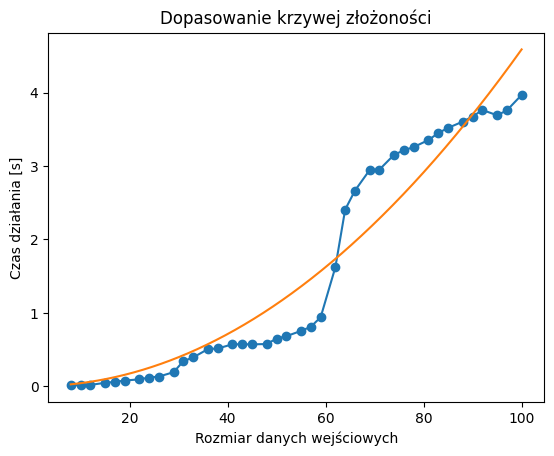

In [ ]:
def model(x, a, deg):
    return a * x ** deg


w = curve_fit(model, sizes, times)[0]
print(w[0], np.round(w[1], 2))

plt.scatter(sizes, times)
plt.plot(sizes, times)
x = np.linspace(8, 100, 1000)
plt.plot(x, model(x, w[0], w[1]))

plt.xlabel("Rozmiar danych wejściowych")
plt.ylabel("Czas działania [s]")
plt.title("Dopasowanie krzywej złożoności")
plt.show()

## Porównanie z NumPy

In [50]:
n = 4
A = generate_random_matrix(n)
b = np.random.rand(n)

print("A =")
print(A)
print(f"b = {b}")

A =
[[0.37792419 0.07962609 0.98281711 0.18161286]
 [0.8118587  0.87496165 0.68841326 0.56949442]
 [0.16097145 0.46688003 0.34517206 0.22503997]
 [0.59251187 0.31226984 0.91630555 0.90963553]]
b = [0.25711829 0.1108913  0.19296273 0.49958417]


In [51]:
A_inv = recursive_matrix_inverse(A)
print("Recursive matrix inverse:")
print(A_inv)

Recursive matrix inverse:
[[ 0.25937966  2.24335044 -3.92362951 -0.48558875]
 [-0.36655885  0.13950977  2.33953436 -0.59294844]
 [ 1.1739274  -0.73117143  1.22300866 -0.07918347]
 [-1.22565182 -0.77261717  0.52062765  1.69895878]]


In [57]:
A_inv_np = np.linalg.inv(A)
print("NumPy matrix inverse:")
print(A_inv_np)

NumPy matrix inverse:
[[ 0.25937966  2.24335044 -3.92362951 -0.48558875]
 [-0.36655885  0.13950977  2.33953436 -0.59294844]
 [ 1.1739274  -0.73117143  1.22300866 -0.07918347]
 [-1.22565182 -0.77261717  0.52062765  1.69895878]]


In [67]:
L, U = lu_recursive(A)
print("Recursive L:")
print(L)
print("Recursive U:")
print(U)

Recursive L:
[[ 1.          0.          0.          0.        ]
 [ 2.1482052   1.          0.          0.        ]
 [ 0.42593581  0.61508625  1.          0.        ]
 [ 1.56780618  0.26627265 -0.30643925  1.        ]]
Recursive U:
[[ 0.37792419  0.07962609  0.98281711  0.18161286]
 [ 0.          0.70390847 -1.42287958  0.17935273]
 [ 0.          0.          0.80174872  0.03736715]
 [ 0.          0.          0.          0.5885958 ]]


In [74]:
print("L * U:")
print(L @ U)

L * U:
[[0.37792419 0.07962609 0.98281711 0.18161286]
 [0.8118587  0.87496165 0.68841326 0.56949442]
 [0.16097145 0.46688003 0.34517206 0.22503997]
 [0.59251187 0.31226984 0.91630555 0.90963553]]


In [75]:
A_det = recursive_determinant_lu(A)
print("Recursive determinant:")
print(A_det)

Recursive determinant:
0.12553831950684474


In [78]:
A_det_np = np.linalg.det(A)
print("NumPy determinant:")
print(A_det_np)

NumPy determinant:
0.12553831950684471


In [81]:
x = recursive_gaussian_elimination(A, b)
print("Recursive Gaussian elimination:")
print(x)

Recursive Gaussian elimination:
[-0.68424742  0.07643672  0.41719395  0.54842062]


In [82]:
x_np = np.linalg.solve(A, b)
print("NumPy Gaussian elimination:")
print(x_np)

NumPy Gaussian elimination:
[-0.68424742  0.07643672  0.41719395  0.54842062]
